# 2D Inference

The following cells present basic 2D (single image) inference with OTAS. The use OTAS Small for 2D semantic segmentation. Batch inference is also supported for 2D segmentation using `single_inference.similarity_batch()` and `single_inference.segmentation_batch()`.

The example image is from the RELLIS-3D dataset [(link)](https://github.com/unmannedlab/RELLIS-3D).

## Similarity

Similarity is directly estimated by the inference helper. When constructing `single_inference`, configuration options can be directly passed to the function as keyword arguments to customise model behaviour. Keyword-argument-names are consistent with the names in `src/config.py` and overwrite the defaults set there.

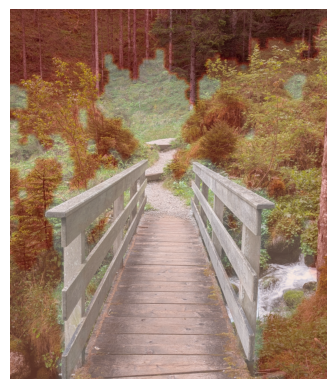

In [27]:
import sys; sys.path.append("src") # Tested in Docker container. Change path to OTAS src folder
from inference import single_inference

from PIL import Image # For visualisation and image loading
import matplotlib.pyplot as plt
import numpy as np

## Model params can be overwritten as arguments. See config.py for available params.
model = single_inference(
    enable_mask_refinement=False,
    n_components=24,
    n_clusters=18,
    dinov2_input_size=518,
    shared_feat_resolution=74,
    dino_scale_factor=2
)

img_path = "/app/otas/img/demo/dataset_demo.png"
img = Image.open(img_path).convert("RGB")

res = model.similarity_single(img, pos_prompts=["conifer"], neg_prompts=["object"])

plt.imshow(img)
plt.imshow(res, cmap="Reds", alpha=0.35)
plt.axis("off")
plt.show()

### Segmentation

The segmentation helper function has the same signature as the similarity function, each consisting of a list of positive and negative prompts. Additionally, a segmentation threshold (default at 0.5) can be set. Both functions (`similarity_single` and `segmentation_single`) return an image in the same shape as the input image.

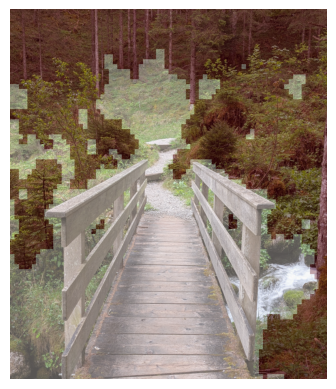

In [30]:
res = model.segmentation_single(img, pos_prompts=["conifer"], neg_prompts=["object"], threshold_value=0.4)

plt.imshow(img)
plt.imshow(res, cmap="Reds", alpha=0.35)
plt.axis("off")
plt.show()

### With Mask Refinement (for fine-grained classes)

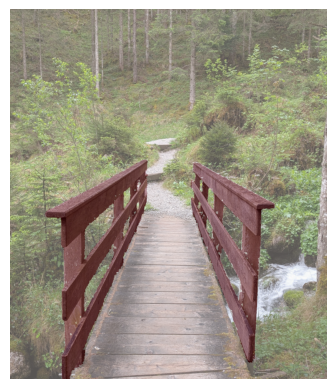

In [33]:
model = single_inference(
    enable_mask_refinement=True,
    n_components=24,
    n_clusters=18,
    dinov2_input_size=518,
    shared_feat_resolution=74,
    dino_scale_factor=2
)

res = model.segmentation_single(img, pos_prompts=["bridge railing"], neg_prompts=["object"], threshold_value=0.9)
plt.imshow(img)
plt.imshow(res, cmap="Reds", alpha=0.35)
plt.axis("off")
plt.show()

---

# OTAS Spatial Inference

Spatial inference requires intrinsic calibration, camera poses and metric depth maps for reconstruction. If not available, inference can be performed with just RGB images using VGGT for internal/external calibration and relative depth and Zoedepth for metric depth.

Alternatively, `inference.py` has helper functions to export to/imoprt from nerfstudio datasets. For imports, the Nerfstudio dataset must include depth images, as specified in the Nerfstudio data conventions [(link)](https://docs.nerf.studio/quickstart/data_conventions.html).

The following cells present a small demo reconstructing a hiking path in the alps from phone photos. Following is one of the 10 images from that dataset.

<img src="./img/demo/dataset_demo.png" alt="Example Image from Dataset" width="250">

## Initialisation from VGGT

To start with 3D reconstruction, we import `spatial_inference` as the OTAS Spatial model and a utility function `all_imgs_in_dir` from the inference helpers. `spatial_inference` has two constructors activated by passing optional keyword arguments. By pointing `vggt_image_paths` to a list of images, the semantic reconstruction can be directly initialised from VGGT without having to provide metric depth and calibration.

In [ ]:
import sys; sys.path.append("src") # Tested in Docker container. Change path to OTAS repository root
from inference import spatial_inference, all_imgs_in_dir

img_paths = all_imgs_in_dir("img/outdoor_reconstruction")

# Similarly to the 2D pipeline, model parameters can be passed as keyword arguments to the constructor
model = spatial_inference(vggt_image_paths = img_paths, # Initialise just from images using VGGT. 
                         voxel_size = 0.2)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[OTAS]: Using custom config from: /src/model_config/OTAS_spatial.json
[OTAS]: Dinov2 pipeline instantiated
[OTAS]: MaskCLIP pipeline instantiated
[OTAS]: Camera calibration pipeline instantiated
[OTAS]: No depth or camera poses provided, estimating from VGGT


/src/inference.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):
/src/foundation_models/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[OTAS]: Masking sky for depth estimation


[OTAS]: Segmentation Batch: 100%|██████████| 10/10 [00:00<00:00, 16.32it/s]


[OTAS]: Scaling depths to metric depth


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
[OTAS]: Semantic Embedding and 3D Projection: 100%|██████████| 10/10 [00:00<00:00, 71.57it/s]
[OTAS]: Backprojecting and pooling embeddings per frame: 100%|██████████| 10/10 [00:00<00:00, 297.55it/s]
[OTAS]: Performing Voxelisation: 100%|██████████| 4898/4898 [00:00<00:00, 46906.96it/s]


When passing a Nerfstudio dataset or initialising from VGGT, reconstruction will immediately be performed. The `model` object can then be masked from semantic similarity or have semantics visualised using PCA.

The following cell loads and cleans up the geometric reconstruction. The resulting pointcloud is then exported using Open3D. The inference helper also provides methods to clean up reconstructed pointclouds (see OTAS supplimental material for further details).

In [ ]:
import open3d as o3d

pcd = model.cleanup_overexposed_pcd(model.pcd_colour)
pcd = model.cleanup_geometric_pcd(pcd)

o3d.io.write_point_cloud("./otas_reconstruction_geometric.ply", pcd)

Similarly to the geometric reconstruction, semantics can be exported as pointclouds.

The following cell visualises the OTAS language embedding in the reconstruction using PCA. The exported pointclouds can be directly visualised using Open3D or CloudCompare.

In [2]:
pcd = model.visualise_pca_pcd()

o3d.io.write_point_cloud("./otas_reconstruction_pca.ply", pcd)

[Open3D WARNING] Write Ply clamped color value to valid range


True

Here are the geometric reconstruction and PCA over language embeddings side by side.

<img src="./img/demo/otas_spatial_demo_colour.png" alt="Geometric Reconstruction Demo" width="500"><img src="./img/demo/otas_spatial_demo_pca.png" alt="PCA over Semantics Demo" width="500">

Instead of visualising semantics using PCA, open-language queries can also be directly performed on the pointcloud. Semantic similarity can be queried with `spatial_inference.query_similarity_pcd`, while segmentation can be performed with `spatial_inference.query_masked_pcd`. The functions will visualise semantic similarity using a colourmap or by filtering the pointcloud respectively.

Similarly to the previous cell, the following cell queries and exports a pointcloud depicting semantic similarity to the bridge seen in some of the input images.

In [3]:
pcd = model.query_similarity_pcd(["wooden bridge"], ["object"])
pcd = model.cleanup_geometric_pcd(pcd)

o3d.io.write_point_cloud("./otas_reconstruction_similarity.ply", pcd)

True

The following plot shows a PCA reconstruction, semantic similarity to _**wooden bridge**_ (seen at the beginning of the example images) alongside the geometric reconstruction.

<img src="./img/demo/otas_spatial_demo_colour.png" alt="Geometric Reconstruction Demo" width="500"><img src="./img/demo/otas_spatial_demo_similarity.png" alt="Similarity to Prompt Demo" width="500">

---

## ROS 2 Visualisation

Instead of saving the reconstructions as pcd files, they can also be published to ROS 2 for visualisation. Make sure to follow the ROS 2 installation steps before running the following code cell.

This code cell first instantiates the reconstruction similarly to the previous examples and then visualises the pointclouds depicting environment geometry, PCA over langauge-grounded features and clusters.

In [1]:
import sys; sys.path.append("src") # Tested in Docker container. Change path to OTAS repository root
from inference import spatial_inference, all_imgs_in_dir

img_paths = all_imgs_in_dir("img/outdoor_reconstruction")
model = spatial_inference(vggt_image_paths = img_paths,
                            voxel_size = 0.4,
                            dino_scale_factor=2,
                            shared_feat_resolution=74,
                            n_components=64,
                            n_clusters=64,
                            cluster_model_type="kmeans_gpu",
                            spatial_use_positional_prior=False,
                            log_time=True)

from ros2_node import OTASVisualizationNode
import rclpy
rclpy.init()
vis = OTASVisualizationNode(convenience_rotate=True) # This option rotates the pointcloud correctly when initialising from VGGT

## Publish reconstruction to ROS 2
vis.pub_geometric(model)
vis.pub_pca(model)
vis.pub_cluster(model)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[OTAS]: Using custom config from: /app/otas/src/model_config/OTAS_spatial.json
[OTAS]: Dinov2 pipeline instantiated
[OTAS]: MaskCLIP pipeline instantiated
[OTAS]: Camera calibration pipeline instantiated
[OTAS]: No depth or camera poses provided, estimating from VGGT


/app/otas/src/foundation_models/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[OTAS]: Masking sky for depth estimation


[OTAS]: Segmentation Batch: 100%|███████████████| 10/10 [00:01<00:00,  5.34it/s]


[OTAS]: Scaling depths to metric depth


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
[OTAS]: Semantic Embedding and 3D Projection: 100%|█| 10/10 [00:00<00:00, 70.66i
[OTAS]: Backprojecting and pooling embeddings per frame: 100%|█| 10/10 [00:00<00
[OTAS]: Performing Voxelisation: 100%|███| 3629/3629 [00:00<00:00, 41760.07it/s]


Reconstruction time: 0.42 seconds


The ROS 2 node can also visualise natural language queries to the feature field as pointclouds depicting similarity or mask. If a constant stream of pointcloud data is required, the `republish_stored_pcds` method republishes already processed pointclouds with low computational cost.

In [4]:
vis.pub_similarity(model, ["gravel path"], neg_prompts=["object"], do_cleanup=True) # Visualises similarity
vis.pub_mask(model, ["gravel path"], neg_prompts=["object"], threshold=0.6, do_cleanup=True) # Visualises mask

In [5]:
vis.republish_stored_pcds()

<img src="./img/demo/ros_reconstruction_demo.gif" alt="Reconstruction Demo in ROS 2" width="600">

---

## Export to Nerfstudio

Once initialised, the model contents can be exported to a dataset for more detailed reconstruction in Nerfstudio or later reloading of the OTAS model without VGGT initialisation. Exported datasets follow the convention set by Nerfstudio, documented [here](https://docs.nerf.studio/quickstart/data_conventions.html). Model export is included as a convenience function with the inference helper.

In [ ]:
model.export_to_ns_data("/app/testdata/otas_forest") # <- replace with your desired path (tested in Docker container)

---

## Initialisation from Nerfstudio Dataset

Instead of initialising from VGGT, the `spatial_inference` class includes a constructor datasets following the Nerfstudio conventions, documented [**here**](https://docs.nerf.studio/quickstart/data_conventions.html). Similarly to Nerfstudio, the model can be pointed directly to the *transforms.json* file. After initialisation from a dataset, inference can be performed similarly to the examples above.

In [ ]:
model = spatial_inference(ns_data_path = "/app/testdata/otas_forest/transforms.json") # <- replace with your desired path (tested in Docker container)

---

# Configuration Options

Default configurations are set in `src/config.py`, with specific configuration options for OTAS Small (fast 2D Segmentation), OTAS Large (precise 2D Segmentation) and OTAS Spatial (3D Reconstruction and Segmentation) and real-time ROS 2 operation being set by configuration files in `src/model_config`.

Configuration can be changed as keyword arguments provided to the inference helpers' constructors (see inference demos). Alternatively, the path to a *.json* file overwriting the default configurations can be passed to the inference helpers' constructors. Under the hood, this will set the `OTAS_CONFIG_PATH` environment variable to point to the configuration file before importing the model.

The following cell changes the configuration to a custom configuration upon inference helper instantiation. Similarly to the keyword arguments from earlier, the configuration file takes all options defined in `src/config.py` and overwrites them.

In [ ]:
import sys; sys.path.append("src") # Tested in Docker container. Change path to OTAS src folder
from inference import single_inference

model = single_inference(config_path="src/model_config/OTAS_minimal.json")

print(model.config)

---

# Summary of Configuration Options

Below is a summary of the available configuration options. For more details on their behaviour inside the model, please refer to the OTAS Paper.


### OTAS Model Params
- `log_time` - Logs OTAS reconstruction time
- `enable_amp_autocast` - Use mixed precision for performance
- `n_clusters` - Number of semantic clusters (set to known number of classes if available)
- `n_components` - Number of PCA components for dimensionality reduction
- `dino_scale_factor` - Scaling factor for DINO features
- `shared_feat_resolution` - Shared feature map resolution
- `dim_reduction_type` - Dimensionality reduction method (e.g., pca_gpu)
- `cluster_model_type` - Clustering algorithm type (use kmeans_gpu for faster operation with slight accuracy trade-off)
- `enable_model_compilation` - Compile backbone models for speedup (increases startup time/memory)

### DINOV2 Backbone
- `dinov2_params` - DINOV2 ViT parameters forwarded to vit_small
  - `patch_size` - Patch size for vision transformer
  - `img_size` - Input image size
  - `init_values` - Initialization values
  - `block_chunks` - Number of block chunks
  - `num_register_tokens` - Number of register tokens
- `dinov2_model_path` - Path to DINOV2 checkpoint
- `dinov2_device` - Target device for DINOV2 model (`cuda` or `cpu` for all device selections)
- `dinov2_input_size` - Input size (518 → 37x37 feat map, 224 → 16x16 feat map)

### CLIP Backbone
- `clip_device` - Target device for CLIP model
- `clip_model_type` - CLIP model architecture type
- `clip_model_path` - Path to CLIP checkpoint

### SAM2
- `sam2_model_config` - SAM2 model configuration file path
- `sam2_model_path` - Path to SAM2 checkpoint
- `sam2_device` - Target device for SAM2 model
- `enable_mask_refinement` - Enable mask refinement post-processing (2D inference only)

### Spatial
- `enable_spatial` - Enable spatial features (disable to skip slow Open3D import)
- `spatial_device` - Target device for spatial processing. Requires approx. 1GB VRAM per 10 input views
- `spatial_max_depth` - Maximum depth value in meters
- `spatial_use_positional_prior` - Use positional prior for spatial clustering. Important for outdoor operation
- `spatial_batch_size` - Maximum number of input frames for model inference. Input will be truncated to this number if exceeded
- `vggt_remove_sky` - Whether or not to segment out the sky when initialising from VGGT

### ROS 2 Mapping Server
- `map_server_threshold` - Similarity threshold for semantic segmentation
- `map_server_neg_prompts` - Negative prompts for segmentation
- `map_server_default_prompt` - Default prompt for language grounding (optional)
- `map_server_publish_rate` - Publishing/Update rate in Hz
- `map_server_pub_geometry` - Publish geometry pointcloud
- `map_server_pub_pca` - Publish PCA visualization
- `map_server_pub_cluster` - Publish cluster visualization
- `map_server_pub_mask` - Publish mask visualization
- `map_server_pub_similarity` - Publish similarity visualization
- `map_server_do_cleanup` - Clean up mapped pointclouds when mapper is idle (takes CPU time)
- `spatial_trunc_strategy` - Strategy for limiting input batch size to spatial_batch_size. Must be `drop_oldest` or `equal_spacing`

### ROS 2 Frame/Topic Configuration
- `ros_world_frame` - World coordinate frame name (will be the common frame for all published pointclouds)
- `ros_camera_optical_frame` - Camera optical frame name
- `ros_rgb_topic` - RGB image topic
- `ros_depth_topic` - Depth image topic
- `ros_camera_info_topic` - Camera info topic (use the depth camera's info here)

### ROS 2 Keyframe Selection
- `ros_keyframe_distance_threshold` - Minimum translation distance in meters for keyframe selection
- `ros_keyframe_rotation_threshold` - Minimum rotation in radians for keyframe selection
- `ros_keyframe_trans_velocity_threshold` - Maximum translation velocity in m/s for keyframe selection
- `ros_keyframe_rotation_velocity_threshold` - Maximum rotation velocity in rad/s for keyframe selection
    